## Lorenz equation

Lorenz equation are described by a system of differential equation. These equation are carachterized by 3 constants $\sigma$, $\beta$ e $\rho$. The system is really sensitive to the initial condition.
  
$$ \frac{dx}{dt} = \sigma (y - x) $$
$$ \frac{dy}{dt} = x (\rho - z) - y $$
$$ \frac{dz}{dt} = x y - \beta z $$

I start using the values sigma = 10, beta = 8/3 and rho = 10, 28 and 35. With these parameter values, I will start to train the network. After this, I will use the network to predict the Lorentz equation behavior for rho 17 and 40.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy import integrate
from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

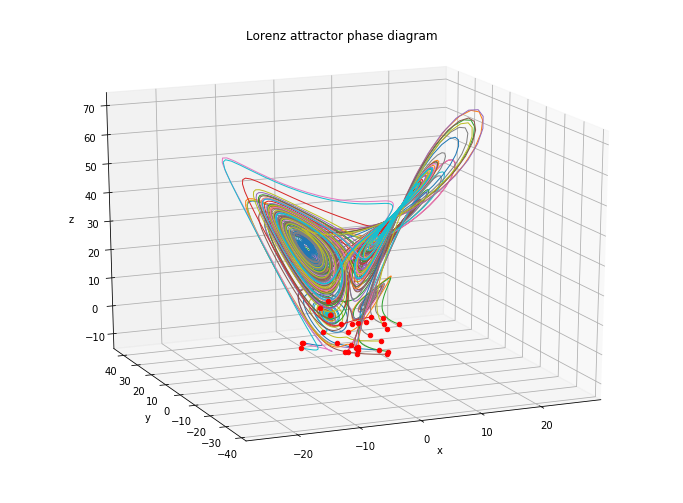

In [2]:
## Simulate the Lorenz System

dt = 0.01
T = 8
t = np.arange(0, T+dt, dt)
beta = 8/3
sigma = 10
rho = [10,28,35]

trial_num = 10

nn_input = np.zeros((trial_num*3*(len(t)-1),4))
nn_output = np.zeros((trial_num*3*(len(t)-1),3))

#fig,ax = plt.subplots(1,1,subplot_kw={'projection': '3d'})
#fig,ax  = plt.figure(figsize=(12, 9))

fig = plt.figure(figsize=(12, 9))
ax = fig.gca(projection='3d')

def lorenz_deriv(x_y_z, t0, sigma=sigma, beta=beta, rho=rho):
    x, y, z = x_y_z
    return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

np.random.seed(123)
x0 = -10 + 20 * np.random.random((trial_num*3, 3))

x0_r =np.append(np.ones((trial_num,1))*rho[0],np.ones((trial_num,1))*rho[1],axis=0)
x0_r =np.append(x0_r,np.ones((trial_num,1))*rho[2], axis=0)
x0_r =np.append(x0,x0_r, axis=1)

x_t = np.asarray([np.append(integrate.odeint(lorenz_deriv, x0_j[:3], t, args=(sigma, beta, x0_j[3])), np.ones((len(t),1))*x0_j[3], axis=1) for x0_j in x0_r])

for j in range(trial_num*3):
    nn_input[j*(len(t)-1):(j+1)*(len(t)-1),:] = x_t[j,:-1,:]
    nn_output[j*(len(t)-1):(j+1)*(len(t)-1),:] = x_t[j,1:,:3]
    x, y, z = x_t[j,:,:3].T
    ax.plot(x, y, z,linewidth=1)
    ax.scatter(x0[j,0],x0[j,1],x0[j,2],color='r')
         

ax.set_title('Lorenz attractor phase diagram')#, fontproperties=title_font)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.view_init(18, -113)
plt.show()

In [3]:
class NeuralNetwork(nn.Module):
    def __init__(self, hn):
        super(NeuralNetwork, self).__init__()
        hnm = int(hn/2)
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(4, hn),
            nn.ReLU(),
            nn.Linear(hn, hn),
            nn.ReLU(),
            nn.Linear(hn, hn),
            nn.ReLU(),
            nn.Linear(hn, hn),
            nn.ReLU(),
            nn.Linear(hn, 3),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits


model = NeuralNetwork(30).to("cpu")

model.double()

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=4, out_features=30, bias=True)
    (1): ReLU()
    (2): Linear(in_features=30, out_features=30, bias=True)
    (3): ReLU()
    (4): Linear(in_features=30, out_features=30, bias=True)
    (5): ReLU()
    (6): Linear(in_features=30, out_features=30, bias=True)
    (7): ReLU()
    (8): Linear(in_features=30, out_features=3, bias=True)
  )
)

In [4]:
u_train, u_test, y_train, y_test = train_test_split(nn_input, nn_output,  test_size=0.2, random_state=100)

tu_train = torch.from_numpy(u_train)
tu_test = torch.from_numpy(u_test)

ty_train = torch.from_numpy(y_train)
ty_test = torch.from_numpy(y_test)


learning_rate = 1e-4
batch_size = 32
epochs = 500

loss_fn = nn.MSELoss(reduction='sum') # Mean Square Error
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [5]:
class LorenzDataset(Dataset):
    def __init__(self, input_data, result, targets=None):
        self.input_ = input_data
        self.output_ = result

    def __len__(self):
        return len(self.input_)

    def __getitem__(self, idx):
        return self.input_[idx,:],self.output_[idx,:]
    

    
l_train = LorenzDataset(u_train, y_train);
l_test = LorenzDataset(u_test, y_test);
l_train_dataloader = DataLoader(l_train, batch_size=batch_size, shuffle=True)
l_test_dataloader = DataLoader(l_test, batch_size=batch_size, shuffle=False)

In [6]:

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        optimizer.zero_grad()
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
            
            
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += np.sqrt((np.power(pred - y,2).sum())/len(y))

    correct /= size
    print(f"Test Error: \n Root Means Square Error: {(100*correct):>0.1f}, Avg loss: {test_loss:>8f} \n")
    
    
if(os.path.isfile('lorenz_weights')):
    model.load_state_dict(torch.load('lorenz_weights'))
    print(model.eval())
else:    
    for tt in range(epochs):
        print(f"Epoch {tt+1}\n-------------------------------")
    #    train_loop(train_dataloader, model, loss_fn, optimizer)
    #    test_loop(test_dataloader, model, loss_fn)
        train_loop(l_train_dataloader, model, loss_fn, optimizer)
        test_loop(l_test_dataloader, model, loss_fn)
    
    torch.save(model.state_dict(), 'lorenz_weights')


model.eval()

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=4, out_features=30, bias=True)
    (1): ReLU()
    (2): Linear(in_features=30, out_features=30, bias=True)
    (3): ReLU()
    (4): Linear(in_features=30, out_features=30, bias=True)
    (5): ReLU()
    (6): Linear(in_features=30, out_features=30, bias=True)
    (7): ReLU()
    (8): Linear(in_features=30, out_features=3, bias=True)
  )
)


NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=4, out_features=30, bias=True)
    (1): ReLU()
    (2): Linear(in_features=30, out_features=30, bias=True)
    (3): ReLU()
    (4): Linear(in_features=30, out_features=30, bias=True)
    (5): ReLU()
    (6): Linear(in_features=30, out_features=30, bias=True)
    (7): ReLU()
    (8): Linear(in_features=30, out_features=3, bias=True)
  )
)

Trial number 1. Taking the first element of $x_0$ (initial condition) vector with $\rho=10$ 

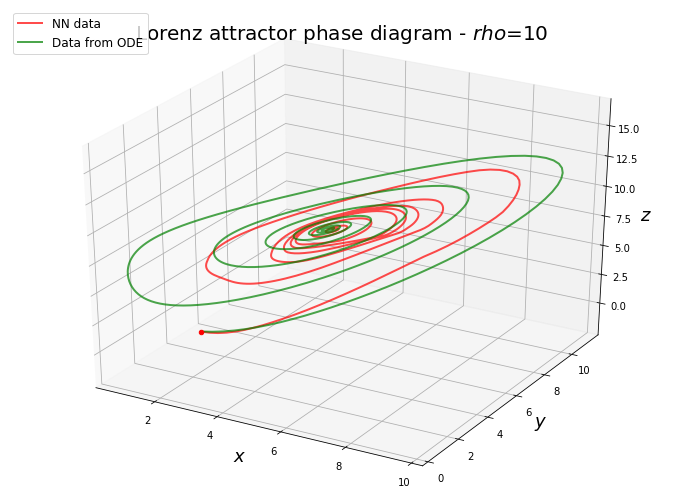

In [7]:
t_init_state = torch.tensor(x0_r[1,:]).double()
init_state = t_init_state[:3]
story = init_state.view(1,len(init_state))
old_res = t_init_state
rho = t_init_state[3]

with torch.no_grad():
    for i in range(len(t)):
        res = model(old_res)
        story = torch.cat((story,res.view(1,len(res))),0)
        old_res = torch.concat((res,torch.ones(1)*rho), axis=0)
        
        
np_story = story.numpy()

x_t = np.asarray(integrate.odeint(lorenz_deriv, t_init_state[:3], t, args=(sigma, beta, t_init_state[3])))

x = np_story[:-1, 0]
y = np_story[:-1, 1]
z = np_story[:-1, 2]

distance_10 = np.sqrt((x_t[:, 0] - x)**2 + (x_t[:, 1] - y)**2 + (x_t[:, 2] - z)**2)
max_distance_10 = np.max(np.sqrt((x)**2 + (y)**2 + (z)**2))


# plot the lorenz attractor in three-dimensional phase space
figure = plt.figure(figsize=(12, 9))
ax = figure.gca(projection='3d')
ax.plot(x, y, z, color='r', alpha=0.7, linewidth=2)
ax.plot(x_t[:, 0], x_t[:, 1], x_t[:, 2], color='g', alpha=0.7, linewidth=2)
ax.set_title('Lorenz attractor phase diagram - $rho$=10', fontsize=20)
ax.legend(['NN data','Data from ODE'], fontsize = 12, loc='upper left')
ax.scatter(x_t[0,0],x_t[0,1],x_t[0,2],color='r')

ax.set_zlabel('$z$', fontsize=18)
ax.set_xlabel('$x$', fontsize=18)
ax.set_ylabel('$y$', fontsize=18)

plt.show()

Trial number 2. Taking one element of $x_0$ (initial condition) vector with $\rho=28$ 

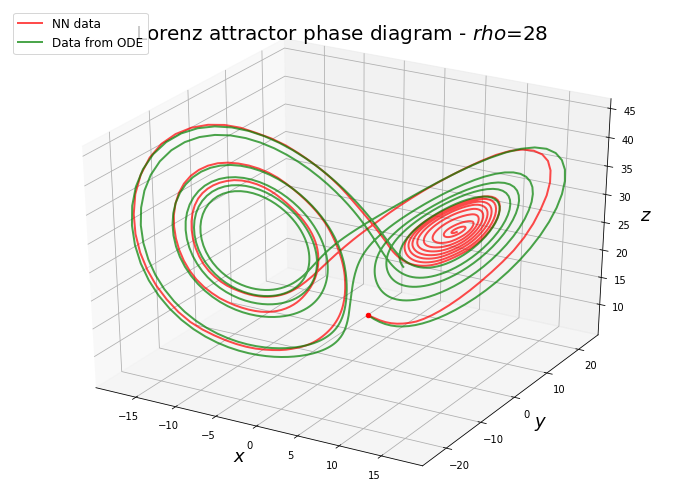

In [8]:
t_init_state = torch.tensor(x0_r[trial_num+2,:]).double()
init_state = t_init_state[:3]
story = init_state.view(1,len(init_state))
old_res = t_init_state
rho = t_init_state[3]

with torch.no_grad():
    for i in range(len(t)):
        res = model(old_res)
        story = torch.cat((story,res.view(1,len(res))),0)
        old_res = torch.concat((res,torch.ones(1)*rho), axis=0)
        
        
np_story = story.numpy()

x_t = np.asarray(integrate.odeint(lorenz_deriv, t_init_state[:3], t, args=(sigma, beta, t_init_state[3])))

x = np_story[:-1, 0]
y = np_story[:-1, 1]
z = np_story[:-1, 2]

distance_28 = np.sqrt((x_t[:, 0] - x)**2 + (x_t[:, 1] - y)**2 + (x_t[:, 2] - z)**2)
max_distance_28 = np.max(np.sqrt((x)**2 + (y)**2 + (z)**2))


# plot the lorenz attractor in three-dimensional phase space
figure = plt.figure(figsize=(12, 9))
ax = figure.gca(projection='3d')
ax.plot(x, y, z, color='r', alpha=0.7, linewidth=2)
ax.plot(x_t[:, 0], x_t[:, 1], x_t[:, 2], color='g', alpha=0.7, linewidth=2)
ax.set_title('Lorenz attractor phase diagram - $rho$=28', fontsize=20)
ax.legend(['NN data','Data from ODE'], fontsize = 12, loc='upper left')
ax.scatter(x_t[0,0],x_t[0,1],x_t[0,2],color='r')

ax.set_zlabel('$z$', fontsize=18)
ax.set_xlabel('$x$', fontsize=18)
ax.set_ylabel('$y$', fontsize=18)

plt.show()

Changing $\rho$ value to $\rho=17$ 

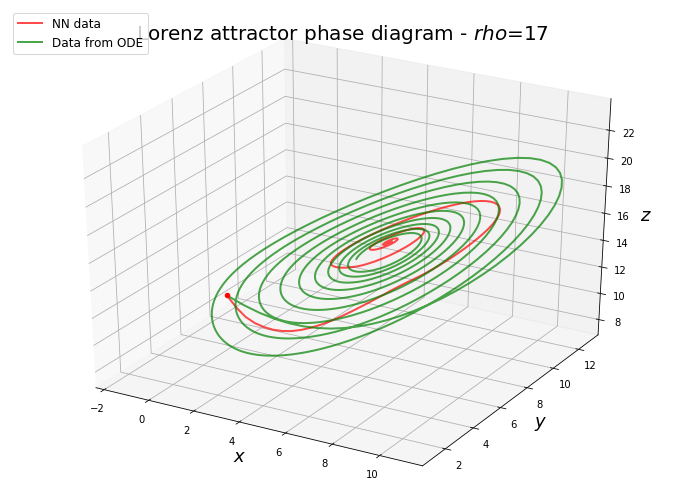

In [9]:
icond=np.append(x0_r[trial_num+2,:3],17)
t_init_state = torch.tensor(icond).double()
init_state = t_init_state[:3]
story = init_state.view(1,len(init_state))
old_res = t_init_state
rho = t_init_state[3]

with torch.no_grad():
    for i in range(len(t)):
        res = model(old_res)
        story = torch.cat((story,res.view(1,len(res))),0)
        old_res = torch.concat((res,torch.ones(1)*rho), axis=0)
        
        
np_story = story.numpy()

x_t = np.asarray(integrate.odeint(lorenz_deriv, t_init_state[:3], t, args=(sigma, beta, t_init_state[3])))

x = np_story[:-1, 0]
y = np_story[:-1, 1]
z = np_story[:-1, 2]

# plot the lorenz attractor in three-dimensional phase space
figure = plt.figure(figsize=(12, 9))
ax = figure.gca(projection='3d')
ax.plot(x, y, z, color='r', alpha=0.7, linewidth=2)
ax.plot(x_t[:, 0], x_t[:, 1], x_t[:, 2], color='g', alpha=0.7, linewidth=2)
ax.set_title('Lorenz attractor phase diagram - $rho$=17', fontsize=20)
ax.legend(['NN data','Data from ODE'], fontsize = 12, loc='upper left')
ax.scatter(x_t[0,0],x_t[0,1],x_t[0,2],color='r')

ax.set_zlabel('$z$', fontsize=18)
ax.set_xlabel('$x$', fontsize=18)
ax.set_ylabel('$y$', fontsize=18)


plt.show()


distance_17 = np.sqrt((x_t[:, 0] - x)**2 + (x_t[:, 1] - y)**2 + (x_t[:, 2] - z)**2)
max_distance_17 = np.max(np.sqrt((x)**2 + (y)**2 + (z)**2))



chaging \rho to 40

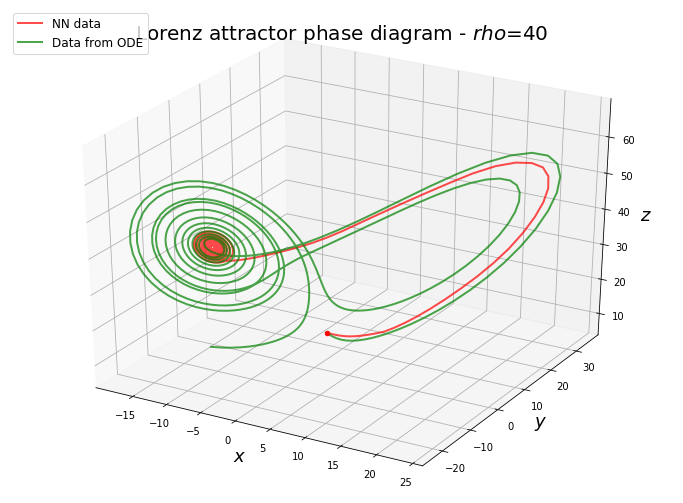

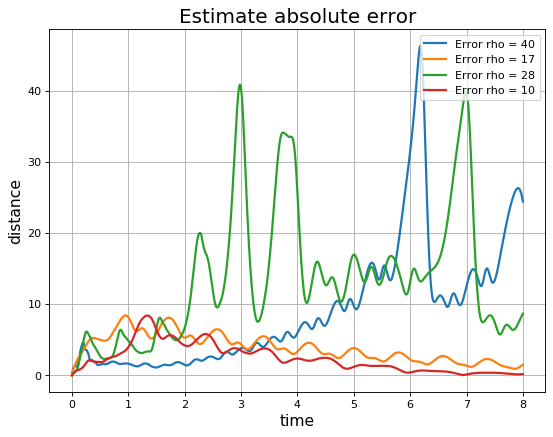

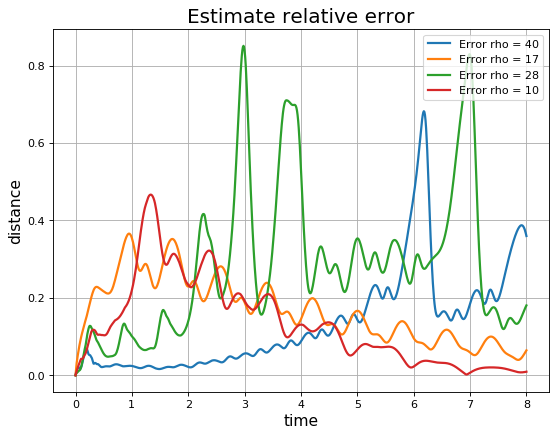

In [10]:
icond=np.append(x0_r[trial_num+2,:3],40)
t_init_state = torch.tensor(icond).double()
init_state = t_init_state[:3]
story = init_state.view(1,len(init_state))
old_res = t_init_state
rho = t_init_state[3]

with torch.no_grad():
    for i in range(len(t)):
        res = model(old_res)
        story = torch.cat((story,res.view(1,len(res))),0)
        old_res = torch.concat((res,torch.ones(1)*rho), axis=0)
        
        
np_story = story.numpy()

x_t = np.asarray(integrate.odeint(lorenz_deriv, t_init_state[:3], t, args=(sigma, beta, t_init_state[3])))

x = np_story[:-1, 0]
y = np_story[:-1, 1]
z = np_story[:-1, 2]

# plot the lorenz attractor in three-dimensional phase space

figure = plt.figure(figsize=(12, 9))
ax = figure.gca(projection='3d')
ax.plot(x, y, z, color='r', alpha=0.7, linewidth=2)
ax.plot(x_t[:, 0], x_t[:, 1], x_t[:, 2], color='g', alpha=0.7, linewidth=2)
ax.set_title('Lorenz attractor phase diagram - $rho$=40', fontsize=20)
ax.legend(['NN data','Data from ODE'], fontsize = 12, loc='upper left')
ax.scatter(x_t[0,0],x_t[0,1],x_t[0,2],color='r')

ax.set_zlabel('$z$', fontsize=18)
ax.set_xlabel('$x$', fontsize=18)
ax.set_ylabel('$y$', fontsize=18)


plt.show()

distance_40 = np.sqrt((x_t[:, 0] - x)**2 + (x_t[:, 1] - y)**2 + (x_t[:, 2] - z)**2)
max_distance_40 = np.max(np.sqrt((x)**2 + (y)**2 + (z)**2))


fig = plt.figure(2,figsize=(8, 6), dpi=80)
line1 = plt.plot(t, distance_40, label='Error rho = 40',color='tab:blue', alpha=1, linewidth=2)
line2 = plt.plot(t, distance_17, label='Error rho = 17',color='tab:orange', alpha=1, linewidth=2)
line3 = plt.plot(t, distance_28, label='Error rho = 28',color='tab:green', alpha=1, linewidth=2)
line4 = plt.plot(t, distance_10, label='Error rho = 10',color='tab:red', alpha=1, linewidth=2)


plt.xlabel('time', fontsize=14)
plt.ylabel('distance', fontsize=14)
plt.title('Estimate absolute error', fontsize=18)
plt.legend(loc='upper right')
plt.grid()
plt.show()


distance_40 = np.sqrt((x_t[:, 0] - x)**2 + (x_t[:, 1] - y)**2 + (x_t[:, 2] - z)**2)
max_distance_40 = np.max(np.sqrt((x)**2 + (y)**2 + (z)**2))


fig = plt.figure(2,figsize=(8, 6), dpi=80)
line1 = plt.plot(t, distance_40/max_distance_40, label='Error rho = 40',color='tab:blue', alpha=1, linewidth=2)
line2 = plt.plot(t, distance_17/max_distance_17, label='Error rho = 17',color='tab:orange', alpha=1, linewidth=2)
line3 = plt.plot(t, distance_28/max_distance_28, label='Error rho = 28',color='tab:green', alpha=1, linewidth=2)
line4 = plt.plot(t, distance_10/max_distance_10, label='Error rho = 10',color='tab:red', alpha=1, linewidth=2)


plt.xlabel('time', fontsize=14)
plt.ylabel('distance', fontsize=14)
plt.title('Estimate relative error', fontsize=18)
plt.legend(loc='upper right')
plt.grid()
plt.show()